# Analysis of data that lacks informative features

Build a pipeline to analyze the N2 dataset.  These results are an example of what you can find when the data lacks informative features.

In [108]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings

In [109]:
# Ignore warnings
warnings.filterwarnings('ignore')

In [110]:
input_file_path = "../../../data/n2.csv"
df = pd.read_csv(input_file_path, header=0, sep=",")

In [111]:
X = df.loc[:, df.columns != 'ctrl/case']

In [112]:
y = df['ctrl/case'].astype('int').tolist()
features = df.columns

In [113]:
print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## Try to learn from all the features

In [115]:
# the number of permutations during a permutation test
num_permutations = 1000

In [116]:
from sklearn.linear_model import Lasso

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso())
])

In [117]:
parametersGrid = {
    "model__alpha": np.arange(0.01, 2, .1)
}

search = GridSearchCV(
    pipeline, 
    parametersGrid, 
    scoring="roc_auc", 
    cv=5, 
    verbose=False
)

### Train the classifier

In [118]:
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
       1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91])},
             scoring='roc_auc', verbose=False)

In [119]:
search.best_params_

{'model__alpha': 0.01}

In [120]:
search.score(X, y)

1.0

### Coefficients and features from the best fit

In [121]:
import math
import pprint

coefficients = search.best_estimator_.named_steps['model'].coef_
tup = list(zip(coefficients, features))
tup = sorted(tup,  key=lambda x: abs(x[0]), reverse=True)
tup = [x for x in tup if not math.isclose(x[0], 0)]
pprint.pprint(tup)

[(-0.09687810936109993, 'TTR'),
 (0.0887806299222524, 'MMP10'),
 (0.07456955839378693, 'SORT1'),
 (-0.04847222854397004, 'FGF2')]


### Permutation Tests

In [122]:
# Add random features and the classifier score should go down.
n_uncorrelated_features = 20
rng = np.random.RandomState(seed=0)
# Use same number of samples as in the psych data and 20 features
X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))

### Permutation test over the data, and data including random features

In [123]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

clf = search
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_psych, perm_scores_psych, pvalue_psych = permutation_test_score(
    clf, X, y, cv=cv, n_permutations=num_permutations, scoring="roc_auc", verbose=False
)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, y, cv=cv, n_permutations=num_permutations, scoring="roc_auc", verbose=False)

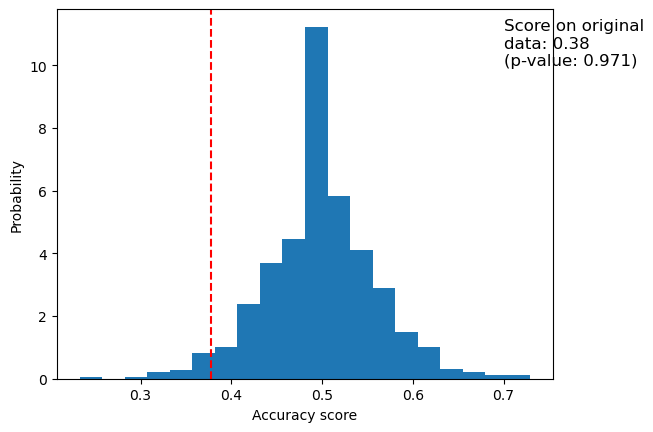

In [124]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(perm_scores_psych, bins=20, density=True)
ax.axvline(score_psych, ls="--", color="r")
score_label = f"Score on original\ndata: {score_psych:.2f}\n(p-value: {pvalue_psych:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

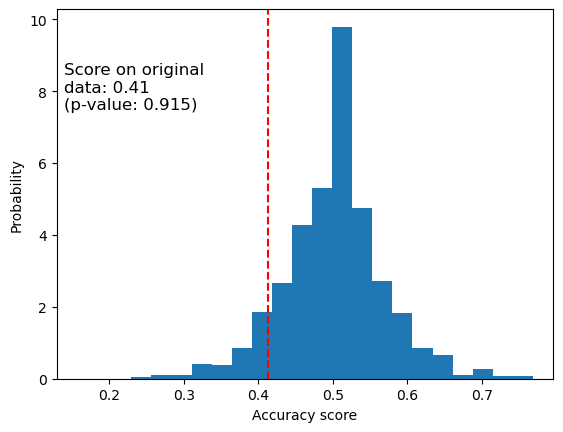

In [125]:
_, ax = plt.subplots()

ax.hist(perm_scores_rand, bins=20, density=True)
ax.set_xlim(0.13)
ax.axvline(score_rand, ls="--", color="r")
score_label = f"Score on original\ndata: {score_rand:.2f}\n(p-value: {pvalue_rand:.3f})"
ax.text(0.14, 7.5, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
plt.show()

## Try to learn from the features selected by an F-test

In [126]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectKBest, f_classif

sfm_lsvc = SelectFromModel(LinearSVC(penalty="l1", dual=False, max_iter=10000))
sfm_lr = SelectFromModel(LogisticRegression(dual=False, solver='liblinear', max_iter=10000))

skb = SelectKBest(f_classif, k=5)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', skb),
    ('model', Lasso())
])

In [127]:
# Look at the parameters revealed by get_params and see which items to include in the grid
parametersGrid = {
    "model__alpha": np.arange(0.01, 2, .1)
}

search = GridSearchCV(
    pipeline, 
    parametersGrid, 
    scoring="roc_auc", 
    cv=5, 
    verbose=False
)

## Train the classifier

In [128]:
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection', SelectKBest(k=5)),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,
       1.11, 1.21, 1.31, 1.41, 1.51, 1.61, 1.71, 1.81, 1.91])},
             scoring='roc_auc', verbose=False)

In [129]:
search.best_params_

{'model__alpha': 0.01}

In [130]:
search.score(X, y)

0.8031250000000001

### Coefficients and features from the best fit

In [131]:
import math
import pprint

coefficients = search.best_estimator_.named_steps['model'].coef_
tup = list(zip(coefficients, features))
tup = sorted(tup,  key=lambda x: abs(x[0]), reverse=True)
tup = [x for x in tup if not math.isclose(x[0], 0)]
pprint.pprint(tup)

[(0.15477039712201454, 'SORT1'),
 (0.13381633055236333, 'TTR'),
 (0.1025959132389977, 'FGF2'),
 (0.037155677196843345, 'MMP10'),
 (0.029658349600763394, 'GCG_0001')]


### Features selected by the F-test

In [132]:
idx = search.best_estimator_.named_steps['feature_selection'].get_support(indices=True)
best_feature_names = [df.columns[i] for i in idx]
best_feature_names

['FAS', 'MMP10', 'CCL2', 'SORT1', 'FGF2']

## Permutation Tests

In [133]:
# Add random features and the classifier score should go down.
n_uncorrelated_features = 20
rng = np.random.RandomState(seed=0)
# Use same number of samples as in the psych data and 20 features
X_rand = rng.normal(size=(X.shape[0], n_uncorrelated_features))

### Permutation test over the data, and data including random features

In [134]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

clf = search
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_psych, perm_scores_psych, pvalue_psych = permutation_test_score(
    clf, X, y, cv=cv, n_permutations=num_permutations, scoring="roc_auc", verbose=False
)

score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    clf, X_rand, y, cv=cv, n_permutations=num_permutations, scoring="roc_auc", verbose=False)

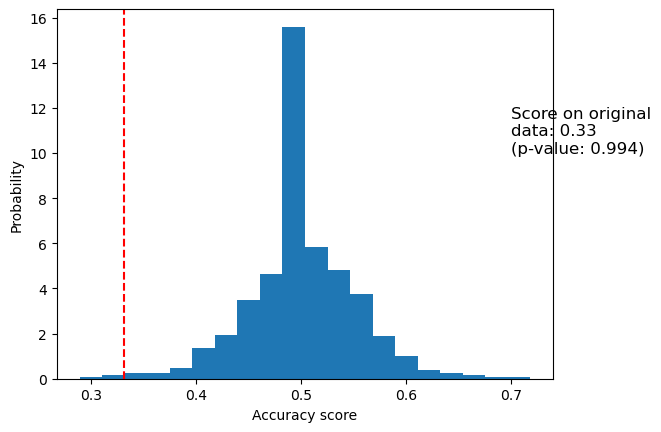

In [135]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist(perm_scores_psych, bins=20, density=True)
ax.axvline(score_psych, ls="--", color="r")
score_label = f"Score on original\ndata: {score_psych:.2f}\n(p-value: {pvalue_psych:.3f})"
ax.text(0.7, 10, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
_ = ax.set_ylabel("Probability")

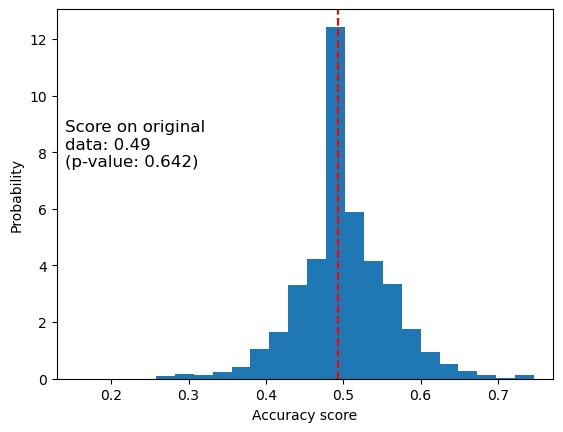

In [136]:
_, ax = plt.subplots()

ax.hist(perm_scores_rand, bins=20, density=True)
ax.set_xlim(0.13)
ax.axvline(score_rand, ls="--", color="r")
score_label = f"Score on original\ndata: {score_rand:.2f}\n(p-value: {pvalue_rand:.3f})"
ax.text(0.14, 7.5, score_label, fontsize=12)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
plt.show()